In [1]:
import pandas as pd

df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [2]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [3]:
# join the offers and transactions table
df = pd.merge(df_offers, df_transactions)
# create a "pivot table" which will give us the number of times each customer responded to a given offer
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
# a little tidying up. fill NA values with 0 and make the index into a column
matrix = matrix.fillna(0).reset_index()
# save a list of the 0/1 columns. we'll use these a bit later
x_cols = matrix.columns[1:]

In [4]:
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=5)
# slice matrix so we only include the 0/1 indicator columns in the clustering
matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[2:]])
matrix.cluster.value_counts()


3    33
1    20
0    19
2    16
4    12
Name: cluster, dtype: int64

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters = matrix[['customer_name', 'cluster', 'x', 'y']]
customer_clusters.head()


offer_id,customer_name,cluster,x,y
0,Adams,4,-1.007580,0.108215
1,Allen,3,0.287539,0.044715
2,Anderson,2,0.392032,1.038391
3,Bailey,4,-0.699477,-0.022542
4,Baker,3,-0.088183,-0.471695


In [11]:
!pip install ggplot

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


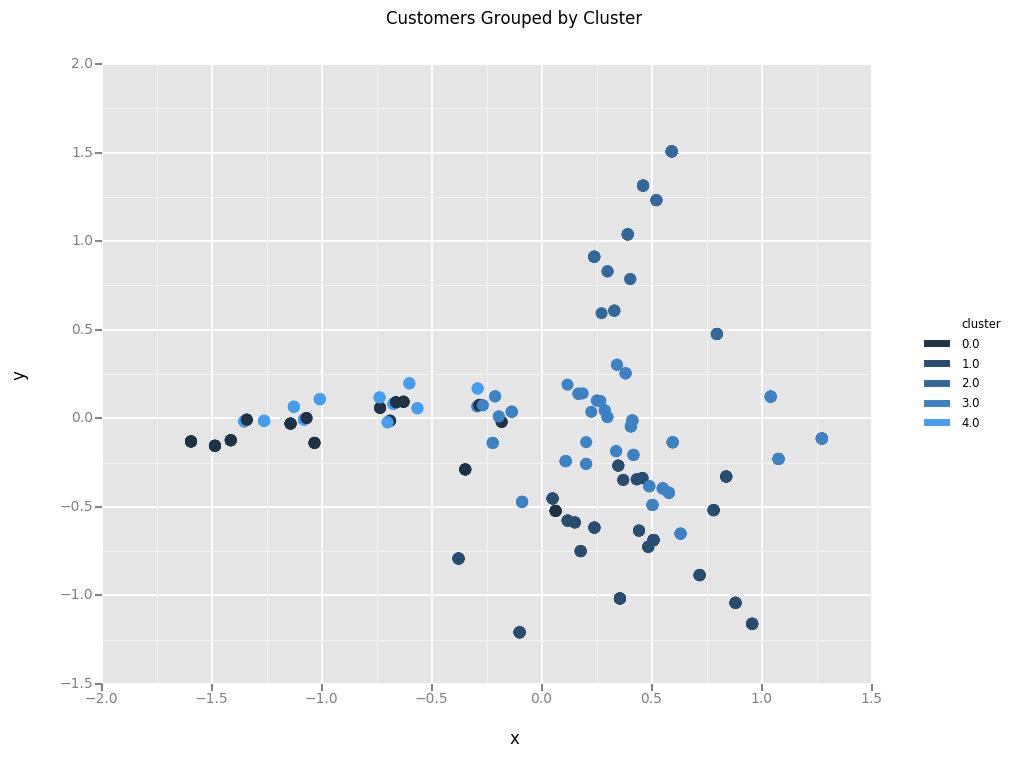

<ggplot: (-9223371882268827900)>

In [12]:
df = pd.merge(df_transactions, customer_clusters)
df = pd.merge(df_offers, df)

from ggplot import *

ggplot(df, aes(x='x', y='y', color='cluster')) + \
    geom_point(size=75) + \
    ggtitle("Customers Grouped by Cluster")

In [15]:
cluster.cluster_centers_

array([[ -2.77555756e-17,   5.26315789e-02,   5.26315789e-02,
         -6.93889390e-18,   5.26315789e-02,   2.10526316e-01,
          8.94736842e-01,  -2.77555756e-17,   5.26315789e-02,
          5.55111512e-17,  -1.38777878e-17,   2.10526316e-01,
         -2.77555756e-17,  -3.46944695e-17,  -1.38777878e-17,
         -2.77555756e-17,   3.68421053e-01,  -1.38777878e-17,
         -3.46944695e-17,  -6.93889390e-18,   0.00000000e+00,
         -1.38777878e-17,  -6.93889390e-17,  -3.46944695e-17,
          2.77555756e-17,   5.26315789e-02,  -3.46944695e-17,
          3.15789474e-01,   5.26315789e-01,   5.26315789e-02,
         -6.93889390e-18],
       [  1.00000000e-01,   2.00000000e-01,   1.50000000e-01,
         -6.93889390e-18,   3.00000000e-01,   1.50000000e-01,
          1.50000000e-01,   1.00000000e-01,   1.00000000e-01,
          2.50000000e-01,   1.00000000e-01,  -3.46944695e-17,
          1.50000000e-01,   1.50000000e-01,  -6.93889390e-18,
         -2.77555756e-17,   5.00000000e-02,

In [13]:
cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))

ggplot(df, aes(x='x', y='y', color='cluster')) + \
    geom_point(size=75) + \
    geom_point(cluster_centers, size=500) +\
    ggtitle("Customers Grouped by Cluster")

ValueError: operands could not be broadcast together with shapes (5,31) (32,) 

In [16]:
df['is_4'] = df.cluster==4
df.groupby("is_4").varietal.value_counts()

is_4   varietal          
False  Champagne             81
       Pinot Noir            44
       Espumante             35
       Prosecco              35
       Cabernet Sauvignon    31
       Malbec                26
       Merlot                18
       Chardonnay            15
       Pinot Grigio           7
True   Pinot Grigio          10
       Prosecco               8
       Malbec                 6
       Espumante              5
       Merlot                 2
       Cabernet Sauvignon     1
Name: varietal, dtype: int64

In [18]:
df.groupby("cluster")[['min_qty', 'discount']].mean()

,min_qty,discount
cluster,,
0,16.000000,53.777778
1,72.866667,60.877778
2,65.581395,52.116279
3,80.800000,64.209524
4,6.187500,59.562500


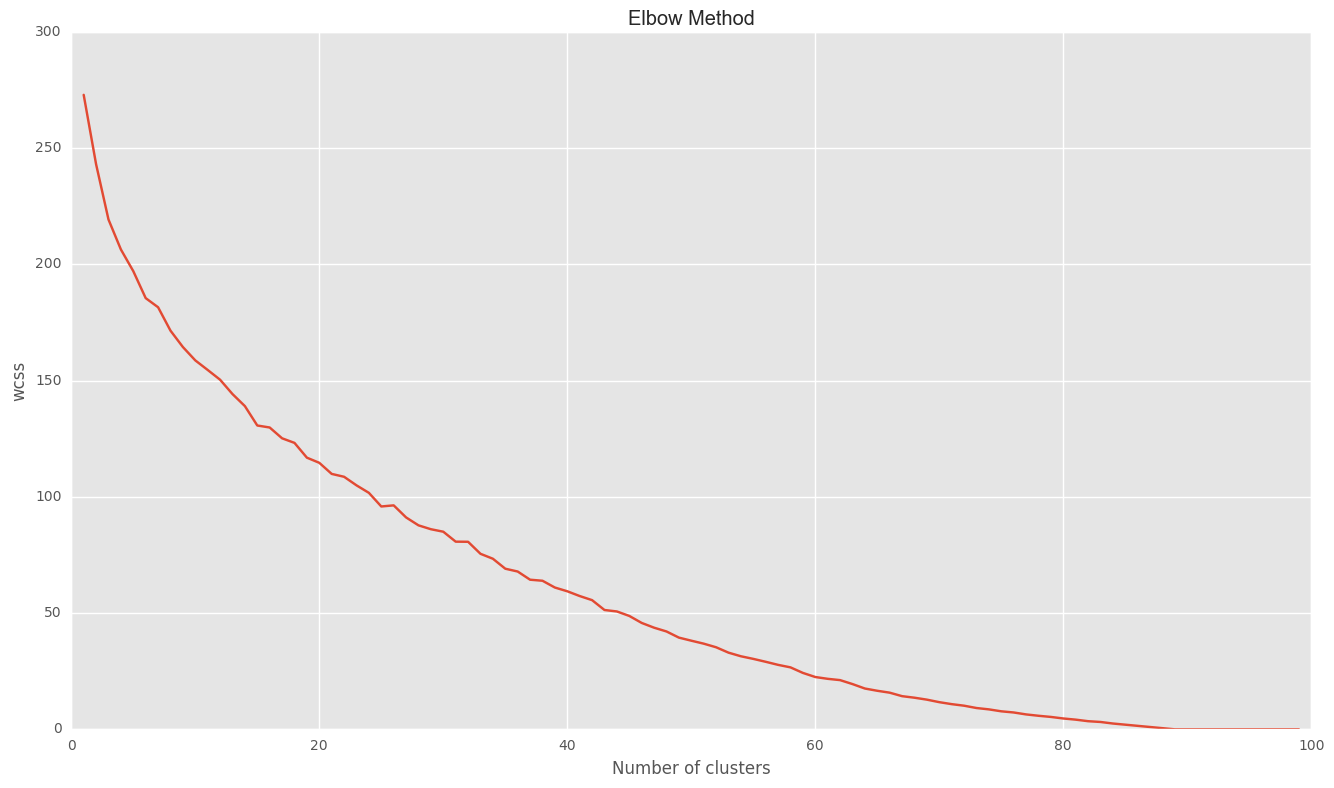

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Plot styling
import seaborn as sns; sns.set()  # for plot styling
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
#Using the elbow method to find the optimum number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1,100):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(matrix[matrix.columns[4:-3]])
    wcss.append(km.inertia_)
plt.plot(range(1,100),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [24]:
matrix[matrix.columns[4:-3]]

offer_id,2,3,4,5,6,7,8,9,10,11,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
